# Image Classification Notebook for womens Apperal



### Scenario: E-commerce Startup Specializing in Women's Accessories

Project Goal: Develop an image classification system to automatically categorize product images on an e-commerce platform specializing in women's accessories.    

Background:

"Accessory Avenue" is a new e-commerce startup that aims to provide a curated selection of women's accessories. To streamline their product cataloging process and improve the user experience on their website, they need an automated system to classify images as either:

Women's Accessory: Images that show items like jewelry, handbags, scarves, hats, belts, watches, etc.
Not Women's Accessory: Images that show other types of clothing (dresses, shirts, shoes, etc.) or non-product images.
Dataset:

The development team will use the "Fashion Products Images" dataset from Kaggle. This dataset contains:

A CSV file ("styles.csv") with metadata about various fashion products, including product ID, gender, article type, subcategory, and image file names.    
A collection of image files corresponding to the products listed in the CSV file.    


### About Dataset
Context
The growing e-commerce industry presents us with a large dataset waiting to be scraped and researched. In addition to professionally shot high-resolution product images, we also have multiple label attributes describing the product which were manually entered while cataloging. To add, we also have descriptive text commenting on the product characteristics.
Content
Each product is identified by an ID like 42431. You will find a map of all the products in styles.csv. From here, you can fetch the image for this product from images/42431.jpg. To get started easily, we have exposed some key product categories and their display names in styles.csv.


In [31]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
from sklearn.metrics import accuracy_score,f1_score,precision_score,recall_score

df = pd.read_csv('../data/styles.csv')


In [2]:
df.head()

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011.0,Casual,Turtle Check Men Navy Blue Shirt
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012.0,Casual,Peter England Men Party Blue Jeans
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016.0,Casual,Titan Women Silver Watch
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011.0,Casual,Manchester United Men Solid Black Track Pants
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012.0,Casual,Puma Men Grey T-shirt


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44441 entries, 0 to 44440
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   id                  44441 non-null  int64  
 1   gender              44441 non-null  object 
 2   masterCategory      44441 non-null  object 
 3   subCategory         44441 non-null  object 
 4   articleType         44441 non-null  object 
 5   baseColour          44426 non-null  object 
 6   season              44420 non-null  object 
 7   year                44440 non-null  float64
 8   usage               44124 non-null  object 
 9   productDisplayName  44434 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 3.4+ MB


In [4]:
df.describe()

,id,year
count,44441.000000,44440.000000
mean,29692.147049,2012.805873
std,17048.746205,2.126410
min,1163.000000,2007.000000
25%,14770.000000,2011.000000
50%,28608.000000,2012.000000
75%,44680.000000,2015.000000
max,60000.000000,2019.000000


In [5]:
print(df['gender'].unique())
print(df['articleType'].unique())
print(df['subCategory'].unique())
print(df['masterCategory'].unique())

['Men' 'Women' 'Boys' 'Girls' 'Unisex']
['Shirts' 'Jeans' 'Watches' 'Track Pants' 'Tshirts' 'Socks' 'Casual Shoes'
 'Belts' 'Flip Flops' 'Handbags' 'Tops' 'Bra' 'Sandals' 'Shoe Accessories'
 'Sweatshirts' 'Deodorant' 'Formal Shoes' 'Bracelet' 'Lipstick' 'Flats'
 'Kurtas' 'Waistcoat' 'Sports Shoes' 'Shorts' 'Briefs' 'Sarees'
 'Perfume and Body Mist' 'Heels' 'Sunglasses' 'Innerwear Vests' 'Pendant'
 'Nail Polish' 'Laptop Bag' 'Scarves' 'Rain Jacket' 'Dresses'
 'Night suits' 'Skirts' 'Wallets' 'Blazers' 'Ring' 'Kurta Sets' 'Clutches'
 'Shrug' 'Backpacks' 'Caps' 'Trousers' 'Earrings' 'Camisoles' 'Boxers'
 'Jewellery Set' 'Dupatta' 'Capris' 'Lip Gloss' 'Bath Robe' 'Mufflers'
 'Tunics' 'Jackets' 'Trunk' 'Lounge Pants' 'Face Wash and Cleanser'
 'Necklace and Chains' 'Duffel Bag' 'Sports Sandals'
 'Foundation and Primer' 'Sweaters' 'Free Gifts' 'Trolley Bag'
 'Tracksuits' 'Swimwear' 'Shoe Laces' 'Fragrance Gift Set' 'Bangle'
 'Nightdress' 'Ties' 'Baby Dolls' 'Leggings' 'Highlighter and Blush'


In [39]:
dummy = df[df['gender'] =='Women']
women_accessories_df = dummy[dummy['masterCategory'].isin(['Accessories', 'Personal Care'])]
count  = women_accessories_df['id'].count() ## nuber of women accessories in the data set.

not_women_acc = df[~df['id'].isin(women_accessories_df['id'])]

# we need to check how many images we have that correspond to women accessories 

positive_images = women_accessories_df['id'].astype(str) + '.jpg'
negative_images = not_women_acc['id'].astype(str) + '.jpg'
positive_images= positive_images[:5000]
negative_images = negative_images[:5000]



testing_pos_images = women_accessories_df['id'].astype(str) + '.jpg'
testing_pos_images = testing_pos_images[5000:]
testing_neg_images = not_women_acc['id'].astype(str) + '.jpg'
testing_neg_images = testing_neg_images[5000:len(women_accessories_df)]

women_accessories_df['label'] = 1
not_women_acc['label'] = 0

print(len(testing_pos_images),len(testing_neg_images))
print(len(positive_images),len(negative_images))

overlap = set(testing_pos_images).intersection(set(positive_images))
print(f"Number of overlapping images : {overlap}")

df_transformed = pd.concat([women_accessories_df, not_women_acc], axis=0).sample(frac=1).reset_index(drop=True)

## unfortunatley to reduce the imbalance created we'll be training the model on 10k images. 5k for the true label and 5k for the false label



2130 2130
5000 5000
Number of overlapping images : set()


C:\Users\thape\AppData\Local\Temp\ipykernel_6528\3692194006.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  women_accessories_df['label'] = 1
C:\Users\thape\AppData\Local\Temp\ipykernel_6528\3692194006.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  not_women_acc['label'] = 0


## EDA on Data before splitting and classifing

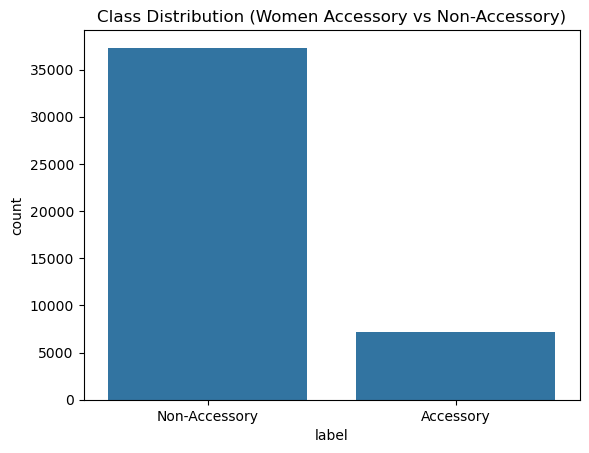

In [7]:
sns.countplot(x='label', data=df_transformed)
plt.title('Class Distribution (Women Accessory vs Non-Accessory)')
plt.xticks([0, 1], ['Non-Accessory', 'Accessory'])
plt.show()

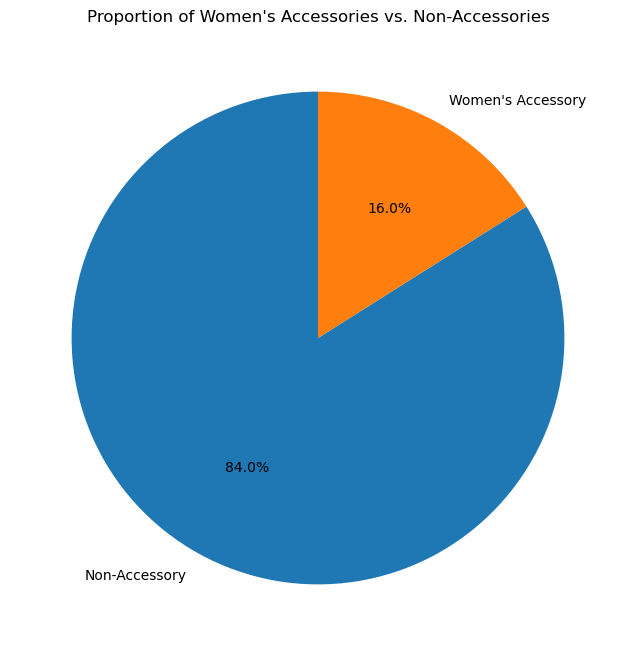

In [8]:
plt.figure(figsize=(8, 8))
df_transformed['label'].value_counts().plot.pie(
    labels=['Non-Accessory', 'Women\'s Accessory'], autopct='%1.1f%%', startangle=90)
plt.title('Proportion of Women\'s Accessories vs. Non-Accessories')
plt.ylabel('')
plt.show()

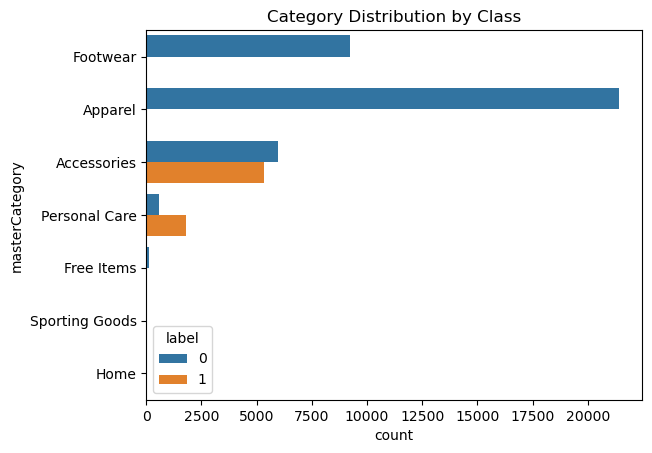

In [9]:
sns.countplot(y='masterCategory', hue='label', data=df_transformed)
plt.title('Category Distribution by Class')
plt.show()

In [10]:
df_transformed.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,label
0,24714,Men,Footwear,Shoes,Casual Shoes,Brown,Fall,2011.0,Casual,Puma Men Volley HP Brown Casual Shoes,0
1,11606,Women,Apparel,Topwear,Kurtas,Grey,Summer,2011.0,Ethnic,W Women Solid Grey Kurtas,0
2,59448,Men,Apparel,Topwear,Shirts,White,Fall,2012.0,Casual,Arrow Sport Men White Check Slim Fit Shirt,0
3,35162,Men,Footwear,Sandal,Sandals,Brown,Fall,2012.0,Casual,Coolers Men Brown Sandals,0
4,37555,Girls,Accessories,Gloves,Gloves,Pink,Summer,2012.0,Casual,Madagascar 3 Infants Girl Pink Mittens,0


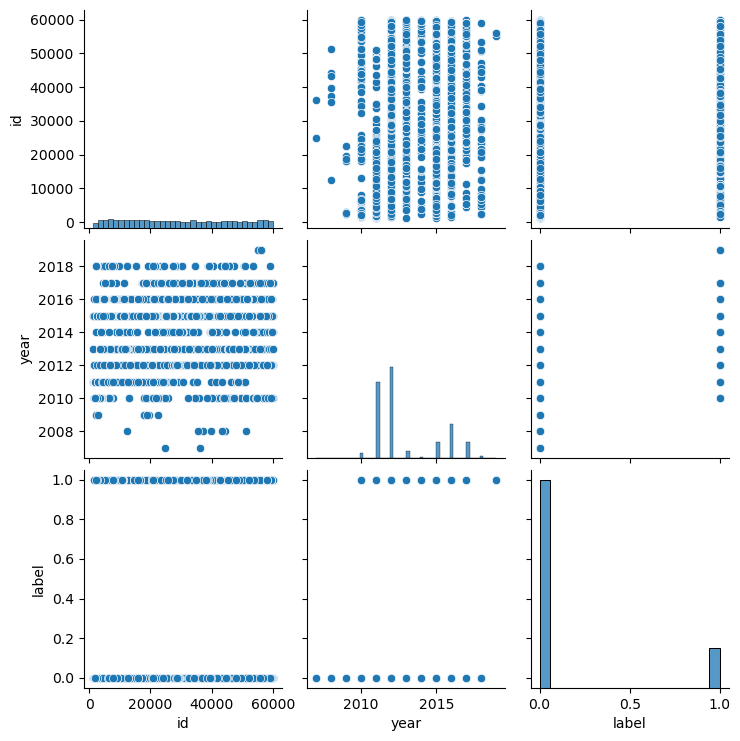

In [11]:
sns.pairplot(data=df_transformed)

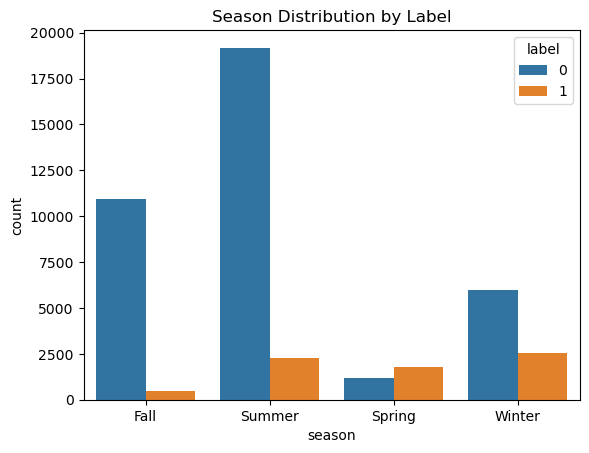

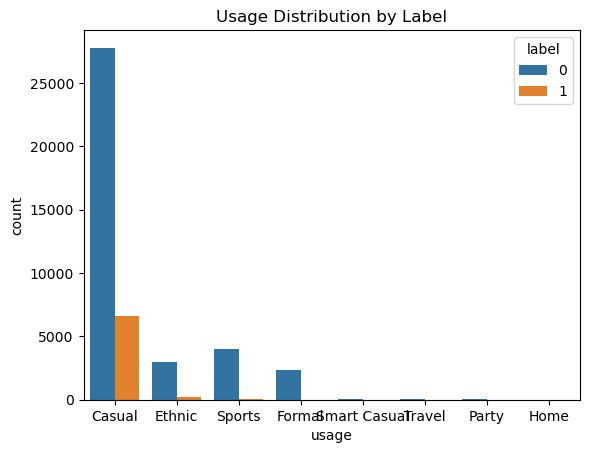

In [12]:
sns.countplot(x='season', hue='label', data=df_transformed)
plt.title('Season Distribution by Label')
plt.show()

# Usage distribution by label
sns.countplot(x='usage', hue='label', data=df_transformed)
plt.title('Usage Distribution by Label')
plt.show()


Top 5 subCategories for label 0:
 subCategory
Topwear       15401
Shoes          7344
Bottomwear     2693
Innerwear      1808
Watches        1640
Name: count, dtype: int64

Top 5 subCategories for label 1:
 subCategory
Bags         2071
Jewellery    1015
Watches       902
Lips          527
Wallets       463
Name: count, dtype: int64


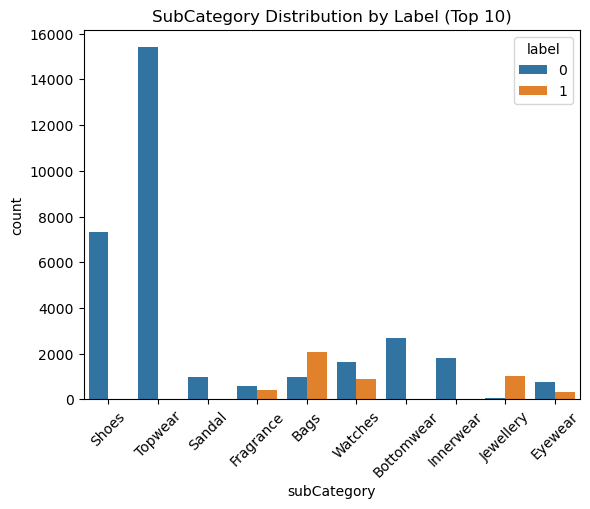

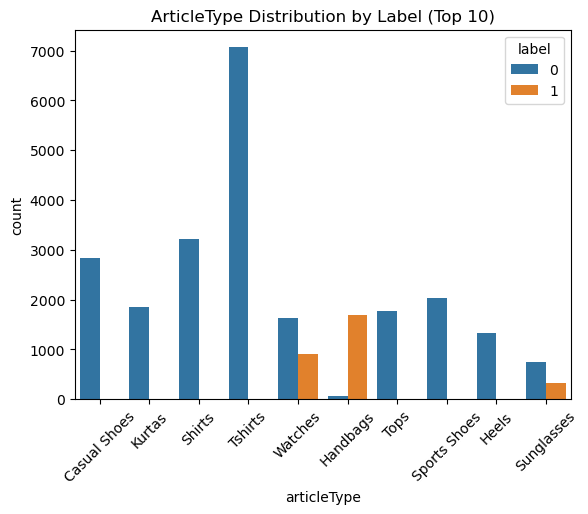

In [13]:
for label in [0, 1]:
    top_subcats = df_transformed[df_transformed['label'] == label]['subCategory'].value_counts().head(5)
    print(f"\nTop 5 subCategories for label {label}:\n", top_subcats)

top_subcats = df_transformed['subCategory'].value_counts().head(10).index
sns.countplot(x='subCategory', hue='label', data=df_transformed[df_transformed['subCategory'].isin(top_subcats)])
plt.title('SubCategory Distribution by Label (Top 10)')
plt.xticks(rotation=45)
plt.show()

top_articles = df_transformed['articleType'].value_counts().head(10).index
sns.countplot(x='articleType', hue='label', data=df_transformed[df_transformed['articleType'].isin(top_articles)])
plt.title('ArticleType Distribution by Label (Top 10)')
plt.xticks(rotation=45)
plt.show()

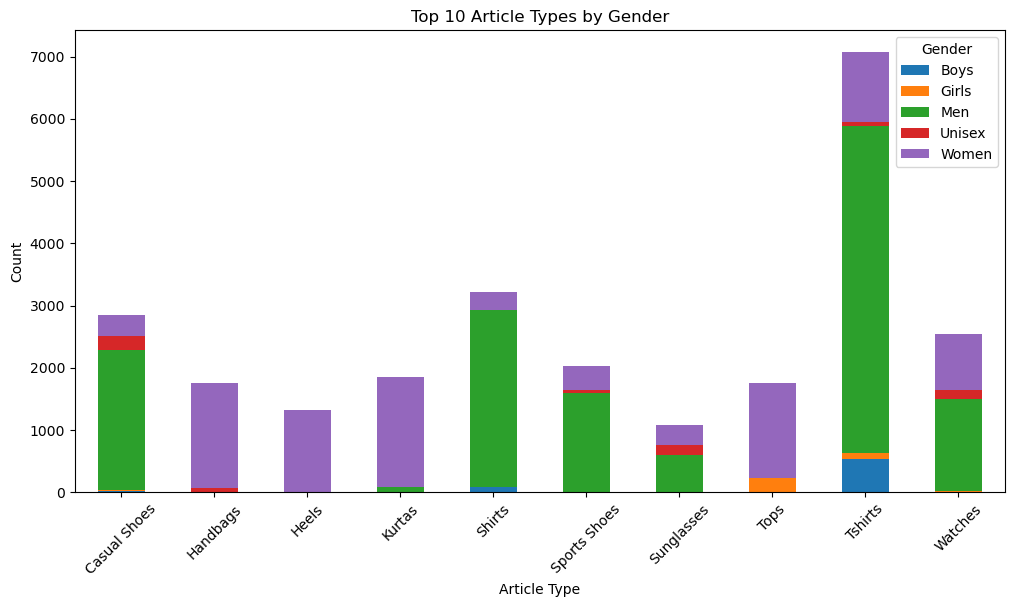

In [14]:
top_article_types = df['articleType'].value_counts().head(10).index
temp_df = df[df['articleType'].isin(top_article_types)]
pivot_table = temp_df.pivot_table(index='articleType', columns='gender', aggfunc='size', fill_value=0)
pivot_table.plot(kind='bar', stacked=True, figsize=(12, 6))
plt.title('Top 10 Article Types by Gender')
plt.xlabel('Article Type')
plt.ylabel('Count')
plt.legend(title='Gender')
plt.xticks(rotation=45)
plt.show()

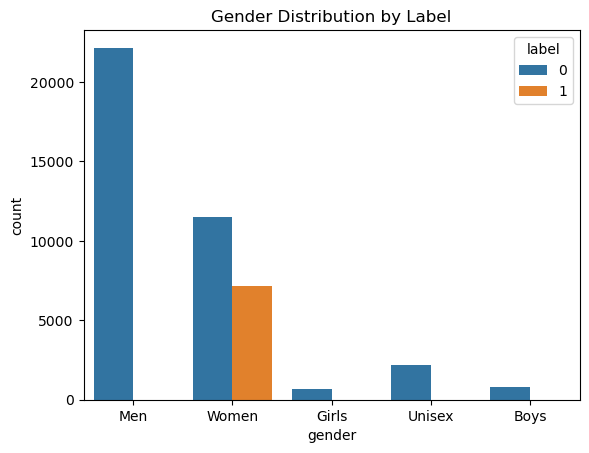

label          0         1
gender                    
Boys    1.000000  0.000000
Girls   1.000000  0.000000
Men     1.000000  0.000000
Unisex  1.000000  0.000000
Women   0.617325  0.382675


In [15]:
sns.countplot(x='gender', hue='label', data=df_transformed)
plt.title('Gender Distribution by Label')
plt.show()
print(pd.crosstab(df_transformed['gender'], df_transformed['label'], normalize='index'))

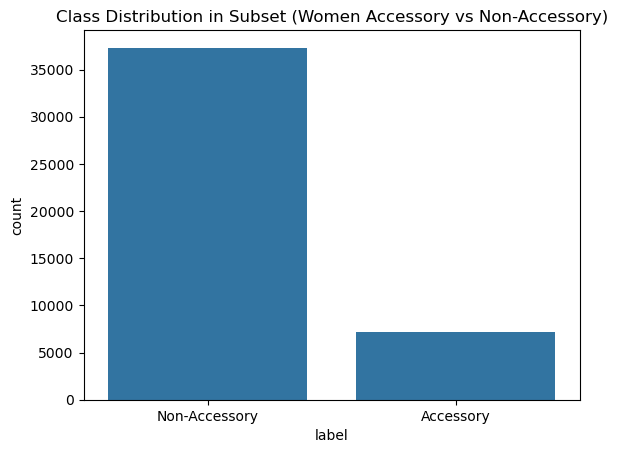

label
0    37311
1     7130
Name: count, dtype: int64


In [16]:
sns.countplot(x='label', data=df_transformed)
plt.title('Class Distribution in Subset (Women Accessory vs Non-Accessory)')
plt.xticks([0, 1], ['Non-Accessory', 'Accessory'])
plt.show()
print(df_transformed['label'].value_counts())

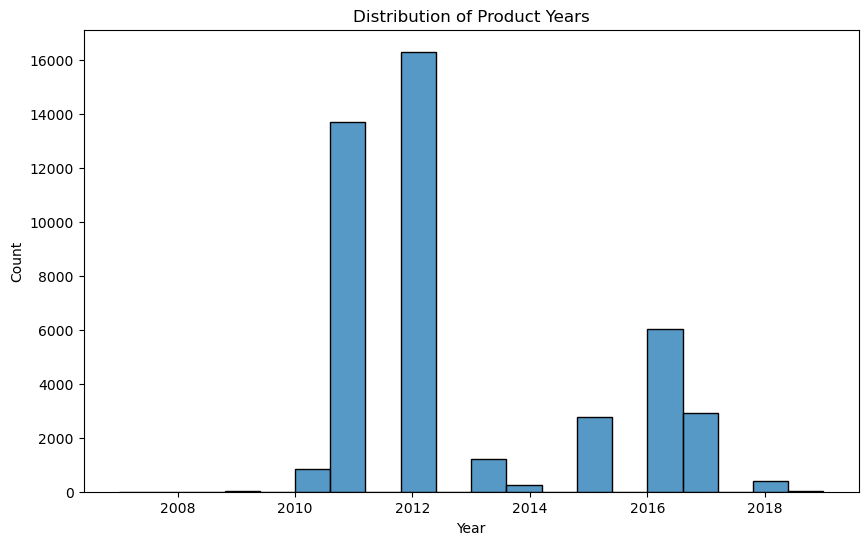

In [17]:
plt.figure(figsize=(10, 6))
sns.histplot(data=df, x='year', bins=20)
plt.title('Distribution of Product Years')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

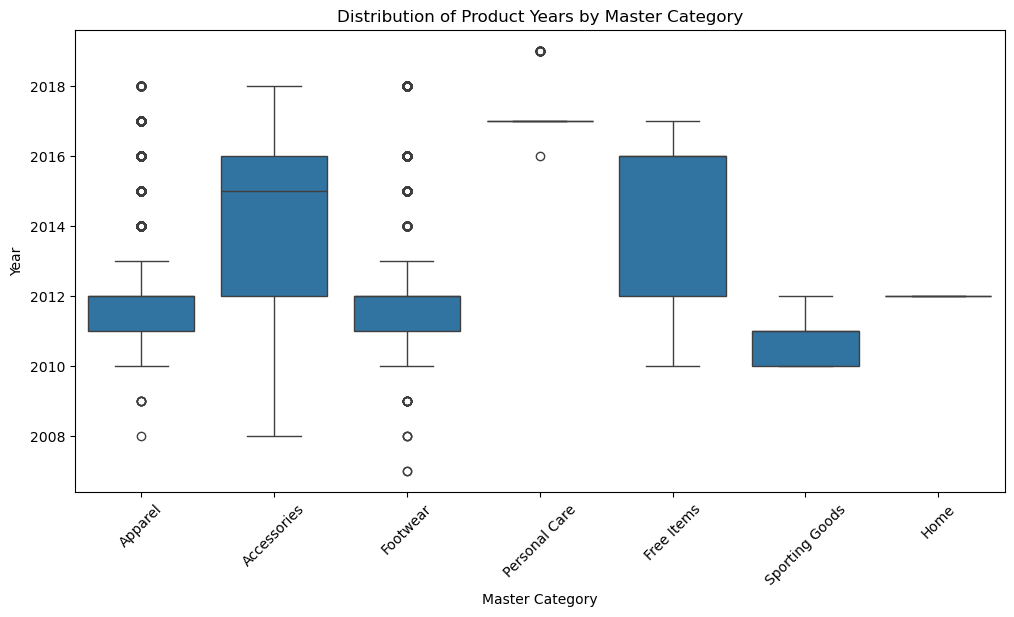

In [18]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='masterCategory', y='year')
plt.title('Distribution of Product Years by Master Category')
plt.xlabel('Master Category')
plt.ylabel('Year')
plt.xticks(rotation=45)
plt.show()

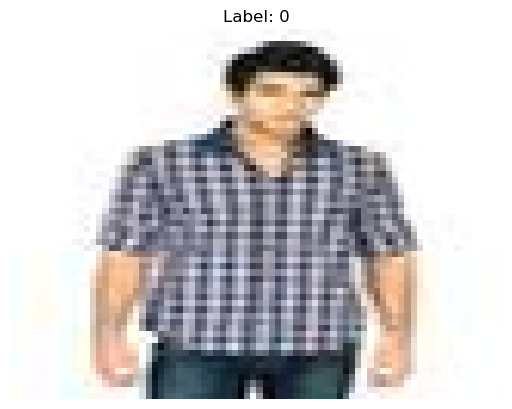

In [19]:
image_size = (80,60) ## to ensure all our images are the same size before we trian our model(They all look like their 60  by 80)

def load_and_process_images(image_path,label): ## we need to make our own labels because we're creating a dataset that has women accessories and non women accessories
    try:
        img =cv2.imread(image_path)
        img = cv2.resize(img,image_size,interpolation=cv2.INTER_LANCZOS4)

        if img.dtype == np.float64:
            # Scale to 0-255 and convert to uint8
            img_converted = (img * 255).astype(np.uint8)
            return img_converted/255, label
        elif img.dtype == np.uint8:
            return img, label

    except:
        return None,None


images =[]
labels = []


## earlier we made sure that each category of images has 7k records. The rest of the images will be used for extensive testing 
for image_file in positive_images:
    image_path = f"../data/images/{image_file}"
    img,label = load_and_process_images(image_path,1)
    if img is not None:
        images.append(img)
        labels.append(label)

for image_file in negative_images:
    image_path = f"../data/images/{image_file}"
    img,label = load_and_process_images(image_path,0)
    if img is not None:
        images.append(img)
        labels.append(label)

processed_images = np.array(images)
processed_labels = np.array(labels)

def display_image(image, label, title=None):
    """Displays a single image with its label."""

    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # OpenCV uses BGR
    plt.title(f"Label: {label}")
    plt.axis('off')  # Turn off axis labels
    if title:
        plt.suptitle(title)
    plt.show()

display_image(processed_images[5000],processed_labels[5000])



In [20]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from sklearn.model_selection import train_test_split
import os

image_size = (80, 60)
batch_size = 32

X_train, X_test, y_train, y_test = train_test_split(
    processed_images, processed_labels, test_size=0.2, random_state=42
)

model = models.Sequential([
    layers.Conv2D(32, (3, 3), activation='relu', input_shape=(image_size[0], image_size[1], 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(1, activation='sigmoid')  # Binary classification
])

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

c:\Users\thape\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 78, 58, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 39, 29, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 37, 27, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 18, 13, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 16, 11, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 8, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 5120)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       655,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 748,865 (2.86 MB)

 Trainable params: 748,865 (2.86 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.7320 - loss: 5.1455 - val_accuracy: 0.8775 - val_loss: 0.3001
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8808 - loss: 0.3046 - val_accuracy: 0.8690 - val_loss: 0.3169
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8989 - loss: 0.2507 - val_accuracy: 0.8665 - val_loss: 0.3164
Epoch 4/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9162 - loss: 0.2113 - val_accuracy: 0.8980 - val_loss: 0.2417
Epoch 5/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9280 - loss: 0.1787 - val_accuracy: 0.8885 - val_loss: 0.2748
Epoch 6/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9282 - loss: 0.1771 - val_accuracy: 0.8885 - val_loss: 0.3183
Epoch 7/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9445 - loss: 0.1363 - val_accuracy: 0.9055 - val_loss: 0.2426
Epoch 8/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.9508 - loss: 0.1261 - val_accu

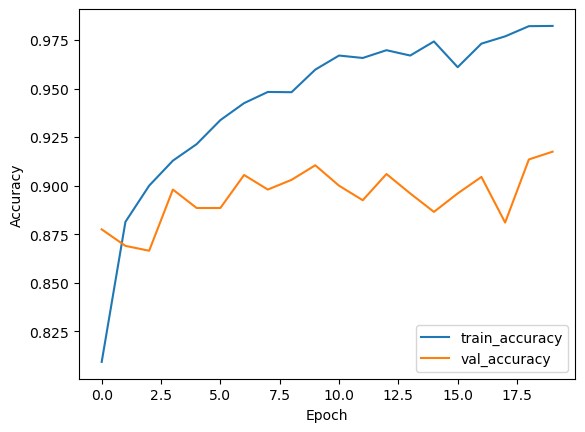

In [ ]:
epochs = 20
history = model.fit(
    X_train, y_train,
    epochs=epochs,
    validation_data=(X_test, y_test)
)

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test accuracy: {accuracy}")

import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='train_accuracy')
plt.plot(history.history['val_accuracy'], label='val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

print()

In [22]:
testing_pos_images = np.array(testing_pos_images)
testing_neg_images = np.array(testing_neg_images)

testing_labels = [1] * len(testing_pos_images) + [0] * len(testing_neg_images)

testing_images = np.concatenate((testing_pos_images,testing_neg_images))

def load_and_process_images(image_path): ## we need to make our own labels because we're creating a dataset that has women accessories and non women accessories
    try:
        img =cv2.imread(image_path)
        img = cv2.resize(img,image_size,interpolation=cv2.INTER_LANCZOS4)

        if img.dtype == np.float64:
            # Scale to 0-255 and convert to uint8
            img_converted = (img * 255).astype(np.uint8)
            return img_converted/255
        elif img.dtype == np.uint8:
            return img

    except:
        return None,None



X_test = np.array([load_and_process_images(f'../data/images/{img}.jpg') for img in testing_images])



In [26]:
predictions_prob = model.predict(X_test)

predictions = (predictions_prob > 0.5).astype(int).flatten()
print(predictions)

# 5. Evaluate the model
accuracy = accuracy_score(testing_labels, predictions)
precision = precision_score(testing_labels, predictions)
recall = recall_score(testing_labels, predictions)
f1 = f1_score(testing_labels, predictions)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")

1389/1389 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step
[1 1 1 ... 0 0 0]
Accuracy: 0.9167
Precision: 0.6657
Recall: 0.9652
F1-Score: 0.7880


In [24]:
model.save(filepath='../Artifacts/imageprediction.h5')

In [25]:
## Model Classifcation 